# Tutorial: Running WRF-Hydro + Pywr-DRB simulations

## Overview

This notebook is used to run WRF-Hydro scenarios using Pywr-DRB.  It assumes you are familiar with the Pywr-DRB API/usage. If not, start with the other Tutorial notebooks before running this one. 

Currently we are set up to run three different WRF-Hydro scenarios:
- "wrf1960s_calib_nlcd2016"
- "wrf2050s_calib_nlcd2016"
- "wrfaorc_calib_nlcd2016" 

You will find input data corresponding to each of these scenarios and Pywr-DRB model nodes in the `Pywr-DRB/input_data/` folder. These data are generated by the `Pywr-DRB/pywrdrb/prep_input_data_wrf_hydro.py` script. This preparation step should _not_ need to be repeated unless you want to change the WRF-Hydro data sources listed in `Pywr-DRB/pywrdrb/pywr_drb_node_data.py`.

The input data for each scenario is labeled as: `"input_data/catchment_inflow_{scenario_name}"`.

For each scenario, this notebook does the following:
- Make a fresh pywrdrb model (JSON file stored in `pywrdrb/model_data`)
- Run the simulation
- Load results
- Plot NYC & Trenton dynamics figure 


In [1]:
# Modify path from this notebook to the root dir
import sys
path_to_pywrdrb = '../'
sys.path.append(path_to_pywrdrb)

REMAKE_MODEL = True
RERUN_SIMULATION = True

In [2]:
import pandas as pd
from pywr.model import Model 
from pywrdrb.utils.dates import model_date_ranges
from pywrdrb.parameters import *

### WRF-Hydro simulation options curreently supported: 
# "wrf1960s_calib_nlcd2016"
# "wrf2050s_calib_nlcd2016"
# "wrfaorc_calib_nlcd2016" 

inflow_type = "wrf1960s_calib_nlcd2016"  

# We use the dataset name to specify the file name
model_filename = f'drb_model_full_{inflow_type}.json'
model_filename = f'{path_to_pywrdrb}/pywrdrb/model_data/{model_filename}'

# Simulation start and end dates
start_date, end_date = model_date_ranges[inflow_type]

### Make a new model JSON file
from pywrdrb.model_builder import PywrdrbModelBuilder

mb = PywrdrbModelBuilder(inflow_type, 
                         start_date, 
                         end_date) # Optional "options" argument is available
mb.make_model()
mb.write_model(model_filename)

In [3]:
### load the pywrdrb model
model = Model.load(model_filename)

# Read model parameter names into a list
model_parameters = [p for p in model.parameters if p.name]

# The pywr.recorders.TablesRecorder class is used store simulation results
# the simulation data is stored in an hdf5 file which is updated during the simulation
from pywr.recorders import TablesRecorder
import warnings
warnings.filterwarnings("ignore")

output_filename = f'drb_output_{inflow_type}.hdf5'
output_filename = f'{path_to_pywrdrb}/output_data/{output_filename}'

if RERUN_SIMULATION:
    ### Add a storage recorder
    TablesRecorder(model = model, 
    			   h5file = output_filename, 
    			   parameters = model_parameters)
    
    ### Run the model
    stats = model.run()

In [4]:
### Load output results
from pywrdrb import Output

models = [inflow_type]
results_sets = [
    'major_flow', 'res_storage', 'mrf_target',
    'res_release', 'reservoir_downstream_gage', 'inflow',
    'ibt_diversions', 'catchment_consumption', 'lower_basin_mrf_contributions',
    'nyc_release_components', 'ffmp_level_boundaries'
]

output = Output(models,
                results_sets = results_sets)
output.load()

### Accessing results:
# output.results_set[model][scenario] -> pd.DataFrame

output.major_flow[inflow_type][0].head(1)

,01417000,01425000,01433500,01436000,01447800,01449800,01463620,01470960,delDRCanal,delLordville,delMontague,delTrenton,outletAssunpink,outletSchuylkill
1959-10-01,288.870063,199.512354,674.432092,195.717508,1291.864737,24.75553,76.711329,968.898553,1275.809248,640.924597,902.365831,1191.563642,125.317928,222.60908


> **Note:** For the 2050s drought, we have re-labeled the datetime indices such that they match the 1960s.  This is necessary because we don't have demand data set up for the future dates.  

Inflows from: Index(['01425000', '01417000', 'delLordville', '01436000', '01433500',
       'delMontague', '01449800', '01447800', 'delDRCanal'],
      dtype='object')
Non-NYC releases from: Index(['prompton', 'wallenpaupack', 'shoholaMarsh', 'mongaupeCombined',
       'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong',
       'nockamixon'],
      dtype='object')
Lower basin MRF contributions from: Index(['beltzvilleCombined', 'blueMarsh', 'nockamixon'], dtype='object')
NYC FFMP target individuals from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP montagueTrentons from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC FFMP flood releases from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')
NYC spills from: Index(['cannonsville', 'pepacton', 'neversink'], dtype='object')


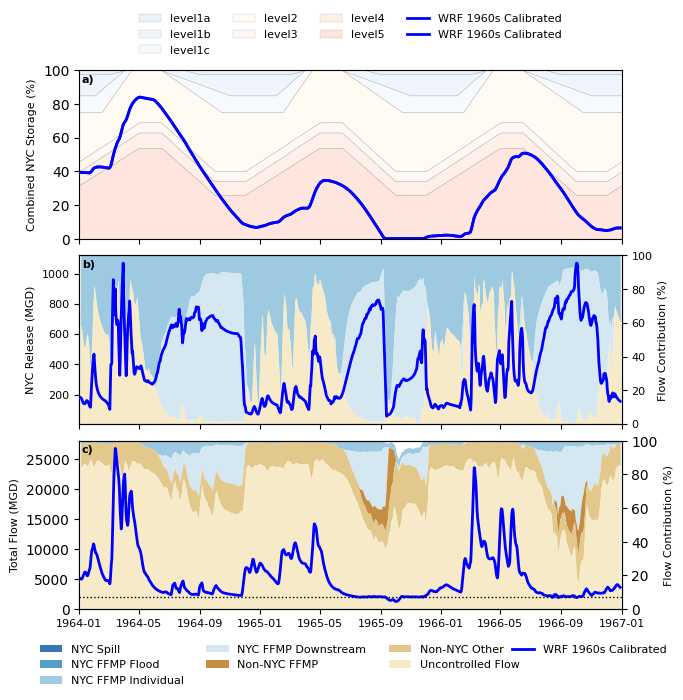

In [5]:
from pywrdrb.plotting.flow_contributions import plot_NYC_release_components_combined

node = 'delTrenton'
start = pd.to_datetime('1964-01-01')
end = pd.to_datetime('1967-01-01')
plot_model_colors = {
    inflow_type : 'blue'
}
fig_dir = './'

plot_NYC_release_components_combined(output.res_storage, 
                                     ffmp_level_boundaries=output.ffmp_level_boundaries[inflow_type][0],
                                 model = inflow_type, 
                                 node = node,
                                 nyc_release_components=output.nyc_release_components,
                                 lower_basin_mrf_contributions=output.lower_basin_mrf_contributions,
                                 reservoir_releases=output.res_release,
                                 reservoir_downstream_gages=output.reservoir_downstream_gage,
                                 major_flows=output.major_flow,
                                 inflows=output.inflow,
                                 diversions=output.ibt_diversions,
                                 consumptions=output.catchment_consumption,
                                 colordict=plot_model_colors,
                                 start_date = start, 
                                 end_date=end,
                                 plot_observed=False,
                                 percentile_cmap=False,
                                 contribution_fill_alpha=0.9,
                                 plot_flow_target=True,
                                 use_log=False,
                                 q_lower_bound=0.01, 
                                 q_upper_bound=0.99,
                                 smoothing_window=7,
                                 fig_dir=fig_dir)
